In [271]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numba as nb
import pandas as pd

import charges as charges
import plotting as plotting
from itertools import combinations
import seaborn as sns

In [272]:
def euclidean_vec(combs):
    """ Compute the euclidean distance between two points
    """

    return np.sqrt((combs[:,0]- combs[:,2])**2 + (combs[:,1]- combs[:,3])**2)
    # return np.linalg.norm(p2 - p1)

def evaluate_configuration_fast(particles):
    """No idea if this is acc faster."""

    # generate combinations
    m, n = particles.shape
    comb = np.zeros((m, m, n + n), dtype=float)
    comb[:, :, :n] = particles[:, None, :]
    comb[:, :, n:] = particles
    comb.shape = (m * m, -1) # shape is 4 columns w len(particles) rows
    # now we also get p1 -p1 combinations, but
    # their inter-particle distance is 0, so we can ignore that fact
    d = euclidean_vec(comb)
    return 1/np.sum(d[d != 0])

def euclidean(p1, p2):
    """ Compute the euclidean distance between two points
    """
    return np.linalg.norm(p2 - p1)

def evaluate_configuration(particles):
    """ Calculate the total energy of the current configuration
    """
    total = 0
    for i, j in list(combinations(range(len(particles)), 2)):
        p1, p2 = particles[i], particles[j]
        total += 1 / euclidean(p1, p2)

    return total

---------------


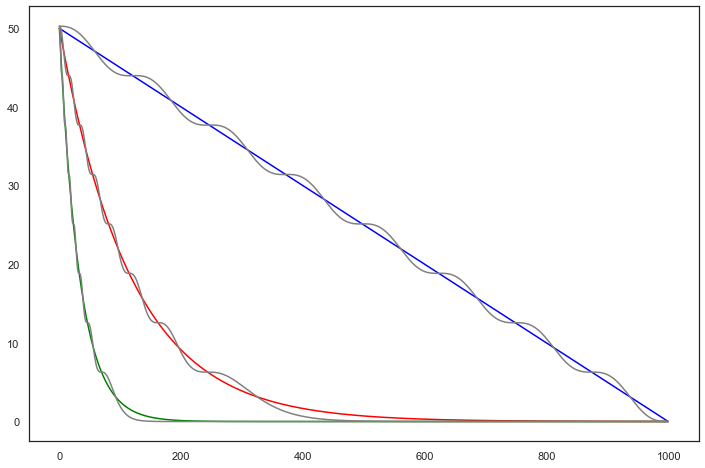

In [273]:
high_temp = 50;
low_temp = 0.01;
n_temps = 1000
wave_func = lambda x: x+np.exp(-0.001*-x)*np.sin(1*-x)
exponential_even = np.geomspace(high_temp, low_temp, n_temps)
exponential_0003 = np.exp(-np.arange(0, n_temps) * 30 / n_temps) * high_temp
linear = np.linspace(high_temp, low_temp, n_temps)


wavy_lin = linear+np.exp(-0.02*-linear)*np.sin(1*-linear)

plt.figure(figsize=(12,8))

plt.plot(linear,color='blue')
plt.plot(exponential_even,color='red')
plt.plot(exponential_0003,color='green')
plt.plot(wave_func(linear),color='grey')
plt.plot(wave_func(exponential_even),color='grey')
plt.plot(wave_func(exponential_0003),color='grey')
# plt.plot(wavy_exp2)
# tst_n = [high_temp * math.exp(-0.001*x) for x in range(n_temps)]

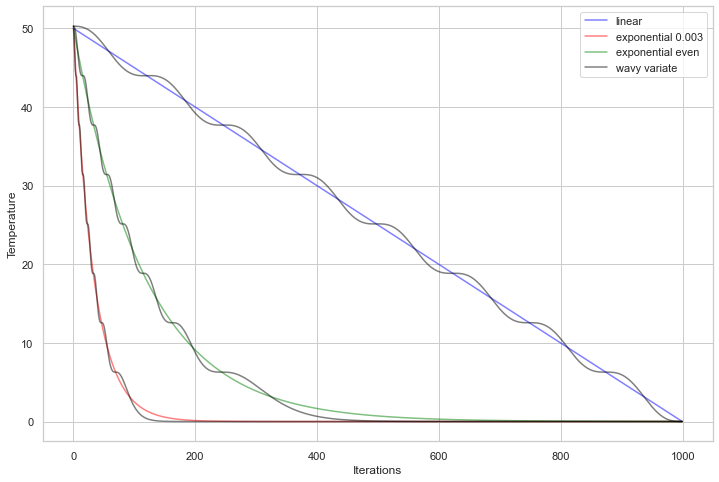

In [274]:
sns.set_theme(style="whitegrid")

# Load an example dataset with long-form data
ax = plt.figure(figsize=(12,8))
# Plot the responses for different events and regions
sns.lineplot(linear,label='linear',color='blue',alpha=0.5)
sns.lineplot(exponential_0003,label='exponential 0.003',color='red',alpha=0.5)
sns.lineplot(exponential_even,label='exponential even',color='green',alpha=0.5)
sns.lineplot(wave_func(linear),color='black',alpha=0.5, label='wavy variate')
sns.lineplot(wave_func(exponential_even),color='black',alpha=0.5)
sns.lineplot(wave_func(exponential_0003),color='black',alpha=0.5)
plt.xlabel("Iterations")
plt.ylabel("Temperature")
# sns.lineplot(x="timepoint", y="signal",
#              hue="region", style="event",
#              data=fmri)
plt.show()

In [275]:
fname = "4_exponential_0.003_100_20"
res_df = pd.read_csv(f"logged_data/{fname}.csv",skiprows=[1]).rename(columns={"Unnamed: 0":"Iterations"})
# res_df = res_df
res_df

,Iterations,Temperatures,Chain_indices,Potential_energy
0,1,5.000000e+01,0,10.107819
1,2,5.000000e+01,0,10.107819
2,3,5.000000e+01,0,9.698260
3,4,5.000000e+01,0,7.838759
4,5,5.000000e+01,0,9.759090
...,...,...,...,...
7994,7995,6.315735e-12,19,3.854151
7995,7996,6.315735e-12,19,3.854151
7996,7997,6.315735e-12,19,3.854151
7997,7998,6.315735e-12,19,3.854151


In [276]:
cap_df = res_df[:3000]

In [277]:
stats = cap_df.groupby(['Temperatures']).agg(['mean', 'sem'])
x_iters = stats["Iterations"]['mean']
stats = stats["Potential_energy"]
stats['ci95_hi'] = stats['mean'] + 1.96* stats['sem']
stats['ci95_lo'] = stats['mean'] - 1.96* stats['sem']
stats = stats.iloc[::-1]

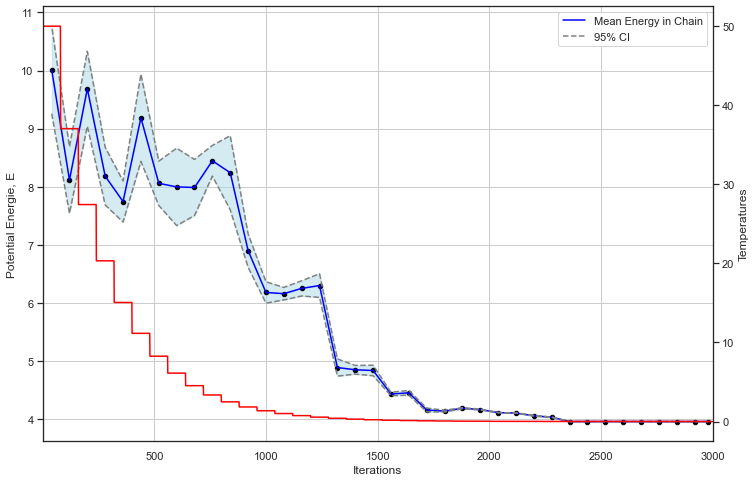

In [278]:
fig = plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid")

ax1 = sns.lineplot(x=x_iters,y=stats['mean'],sort=False,color='blue', label='Mean Energy in Chain')
# CI
sns.lineplot(ax=ax1, x=x_iters,y=stats['ci95_hi'],sort=False,color='grey',linestyle='--', label = '95% CI')
sns.lineplot(ax=ax1, x=x_iters,y=stats['ci95_lo'],sort=False,color='grey',linestyle='--')
ax1.fill_between(x_iters[::-1],stats['mean'],stats['ci95_hi'],color='lightblue',alpha=0.5)
ax1.fill_between(x_iters[::-1],stats['mean'],stats['ci95_lo'],color='lightblue',alpha=0.5)
ax1.scatter(x_iters[::-1],stats['mean'],color='black',s=20)

sns.set_theme(style="white")
ax2 = ax1.twinx()
sns.lineplot(ax=ax2,x=cap_df["Iterations"],y=cap_df["Temperatures"],color='red')

ax1.set_ylabel("Potential Energie, E")
ax1.set_xlabel("Iterations")
plt.xlim((1,3000))
plt.show()

In [279]:
def plot_convergence(fname,pic_name,first_n_iters=None):
    res_df = pd.read_csv(f"logged_data/{fname}.csv", skiprows=[1]).rename(columns={"Unnamed: 0": "Iterations"})
    if first_n_iters:
        res_df = res_df[:first_n_iters]


    # calculate mean and 95% ci for temperature level
    stats = res_df.groupby(['Temperatures']).agg(['mean', 'sem'])
    x_iters = stats["Iterations"]['mean']
    stats = stats["Potential_energy"]
    stats['ci95_hi'] = stats['mean'] + 1.96 * stats['sem']
    stats['ci95_lo'] = stats['mean'] - 1.96 * stats['sem']
    stats = stats.iloc[::-1]

    # draw
    plt.figure(figsize=(12, 8))
    sns.set_theme(style="whitegrid")

    ax1 = sns.lineplot(x=x_iters, y=stats['mean'], sort=False, color='blue', label='Mean Energy in Chain')
    sns.lineplot(ax=ax1, x=x_iters, y=stats['ci95_hi'], sort=False, color='grey', linestyle='--', label='95% CI')
    sns.lineplot(ax=ax1, x=x_iters, y=stats['ci95_lo'], sort=False, color='grey', linestyle='--')
    ax1.fill_between(x_iters[::-1], stats['mean'], stats['ci95_hi'], color='lightblue', alpha=0.5)
    ax1.fill_between(x_iters[::-1], stats['mean'], stats['ci95_lo'], color='lightblue', alpha=0.5)
    ax1.scatter(x_iters[::-1], stats['mean'], color='black', s=20)

    sns.set_theme(style="white")
    ax2 = ax1.twinx()
    sns.lineplot(ax=ax2, x=res_df["Iterations"], y=res_df["Temperatures"], color='red')

    ax1.set_ylabel("Potential Energie, E")
    ax1.set_xlabel("Iterations")
    plt.xlim((1, 3000))
    plt.savefig(pic_name,dpi=300,bbox_inches='tight')

In [280]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
import matplotlib.cm as cm

def plot_ez(init_points, res):
    points = res

    theta = np.linspace(0, 2 * np.pi, 150)
    a = 1 * np.cos(theta)
    b = 1 * np.sin(theta)

    fig, ax = plt.subplots(1, figsize = (8,8))
    ax.plot(a, b, color='black')
    # plotpoints = []
    # for p in points:
    colors = list(cm.rainbow(np.linspace(0, 1, len(points))))
    for i in range(len(points)):
        ax.scatter(init_points[i,0], init_points[i,1],color=colors[i])
        ax.scatter(points[i,0], points[i,1],s=100,marker='X',color=colors[i])
    # scatter = ax.scatter(init_points[:,0], init_points[:,1], color='black',label='before')
    # scatter = ax.scatter(points[:,0], points[:,1], color='red',s=100,marker='x', label = 'black')
    plt.title("%d" % len(res))
    ax.set_aspect(1)
    # plt.legend()

In [ ]:
#test
low_temp = 0.1
high_temp = 50
n_temps = 100
schedule = "exponential_0.003"
chain_length = 20
n_charges = 4

my_charge = charges.Charges(n_charges,1,step_size=0.001)
init_points = my_charge.particles
# print(init_points)
# my_charge.evaluate_configuration()
# my_charge.evaluate_configuration_fast() # does not work, div by 0
# colors = cm.rainbow(np.linspace(0, 1, len(init_points)))


res = my_charge.iterate_SA_optimize(low_temp, high_temp, n_temps, schedule, chain_length,)

# evaluate_configuration_fast(res)

# m, n = res.shape
# comb = np.zeros((m, m, n + n), dtype=float)
# comb[:, :, :n] = res[:, None, :]
# comb[:, :, n:] = res
# comb.shape = (m * m, -1) # shape is 4 columns w len(particles) rows
# print(comb)
# # now we also get p1 -p1 combinations, but
# # their inter-particle distance is 0, so we can ignore that fact
#
# 1/np.sum(euclidean_vec(comb))



In [ ]:
plot_ez(res,res)

In [ ]:
print(evaluate_configuration_fast(init_points))
print(evaluate_configuration_fast(res))

In [ ]:
my_data = np.loadtxt('logged_data/20_exponential_0.003_200000.csv', delimiter=',',skiprows=1)

In [ ]:
my_data

In [ ]:
plt.plot(my_data)